In [90]:
from bs4 import BeautifulSoup
import urllib.request
from pyspark import SparkContext 
import json
import matplotlib.pyplot as plt
import re
import numpy as np

def get_bookinf(asin):
    try:
        url = 'https://www.abebooks.com/servlet/SearchResults?cm_sp=SearchF-_-topnav-_-Results&kn=' + str(asin) +'&sts=t'
        page = urllib.request.urlopen(url)
        soup = BeautifulSoup(page,'html.parser')
        div = soup.find('div', attrs = {'id':'book-1'})
        results = div.find_all('meta')
        inf = []
        for result in results:
            inf.append(result['content'])
        return [inf[1],inf[2]]
    except IOError:
        return "no book found"
def remove_cov(strs):
    return re.sub('\(.*?\)','',strs)

In [91]:
sc = SparkContext.getOrCreate()
total_lines = sc.textFile('Books_5.json').map(lambda trow: json.loads(trow))
asin_num = total_lines.map(lambda inf: (inf['asin'],1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending=False)

In [92]:
book_name = []
book_sale = []

for i in range(0,10):
    book_name.append(remove_cov(get_bookinf(asin_num.collect()[i][0])[0]))
    book_sale.append(asin_num.collect()[i][1])
    

In [93]:
book_name

['Gone Girl',
 'The Hunger Games',
 'The Book Thief',
 'Sycamore Row ',
 'Mockingjay ',
 'The Goldfinch: A Novel ',
 'Inferno',
 'Allegiant',
 'Hopeless',
 "The Husband's Secret"]

Text(0.5, 1.0, 'Top 10 book sale')

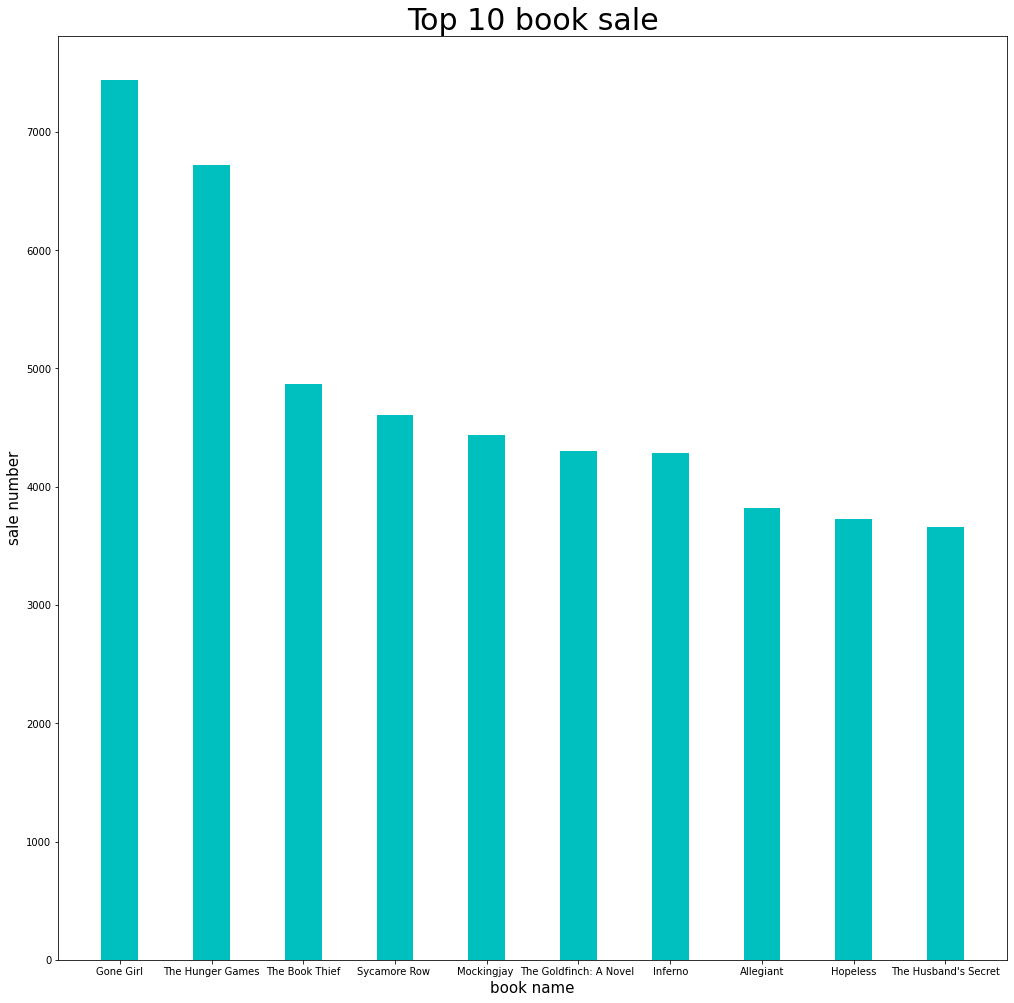

In [34]:
plt.figure(figsize = (17,17))
plt.bar(book_name,book_sale,0.4,color = 'c')
plt.xlabel("book name",fontsize = 15)
plt.ylabel("sale number",fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.title("Top 10 book sale",fontsize = 30)

In [38]:
sale_peryear = total_lines.map(lambda inf: (inf['reviewTime'].split(',')[-1],1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending=False)

In [62]:
year_co = sorted(sale_peryear.collect(),key = lambda x: (int(x[0])))

In [63]:
year = []
sale_num = []
for row in year_co:
    year.append(row[0])
    sale_num.append(row[1])

Text(0.5, 1.0, '1996 - 2014 book sale comparsion')

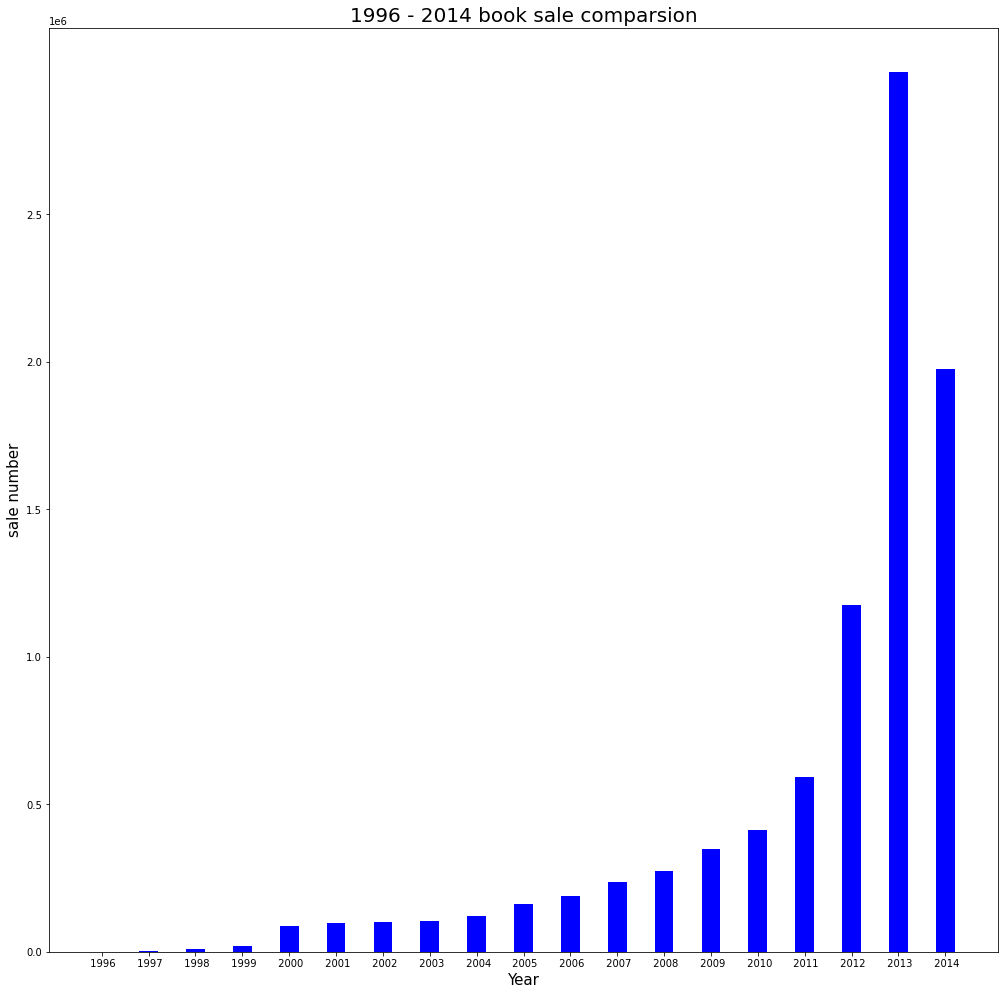

In [64]:
plt.figure(figsize = (17,17))
plt.bar(year,sale_num,0.4,color = 'b')
plt.xlabel("Year",fontsize = 15)
plt.ylabel("sale number",fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
y_ticks = np.arange(0,3000000,500000)
plt.yticks(y_ticks)
plt.title("1996 - 2014 book sale comparsion",fontsize = 20)

In [71]:
review_num = {}
for rows in asin_num.collect():
    if rows[0] not in review_num.keys():
        review_num[rows[0]] = rows[1]
    else:
        review_num[rows[0]].append(rows[1])

In [68]:
rate_avg = total_lines.map(lambda inf: (inf['asin'],float(inf['overall']))).reduceByKey(lambda x, y: x + y)

In [97]:
book_rate = []
for data in rate_avg.collect():
    if review_num[data[0]] >= 1000:
        book_rate.append([data[0], data[1]/review_num[data[0]]])
    

In [98]:
sort_rate = sorted(book_rate, key = lambda x : -x[1])

In [118]:
books = []
rate = []
for n in range(0,5):
    books.append(remove_cov(get_bookinf(sort_rate[n][0])[0]))
    rate.append(sort_rate[n][1])

In [119]:
books

['Crashed ', "Archer's Voice ", 'Fueled ', 'Maybe Someday', 'Making Faces']

In [120]:
rate

[4.878682842287695,
 4.875,
 4.872198667474258,
 4.819417475728155,
 4.816081330868761]

Text(0.5, 1.0, 'Top 5 popular books rate')

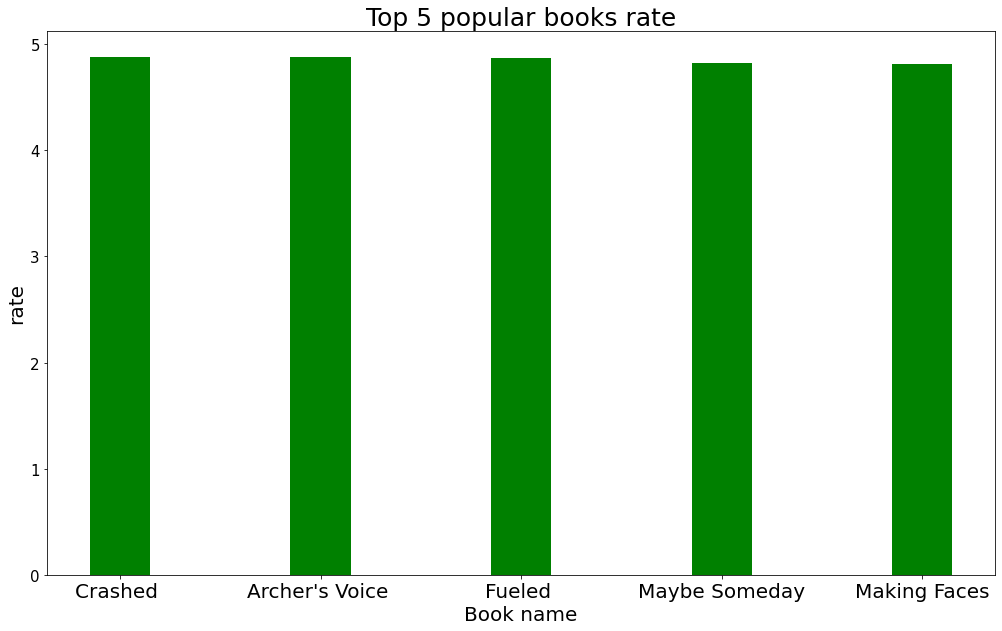

In [134]:
plt.figure(figsize = (17,10))
plt.bar(books,rate,0.3,color = 'green')
plt.xlabel("Book name",fontsize = 20)
plt.ylabel("rate",fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 15)
plt.title("Top 5 popular books rate",fontsize = 25)